In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download --force -d tanlikesmath/diabetic-retinopathy-resized

100% 7.24G/7.25G [00:38<00:00, 278MB/s]
100% 7.25G/7.25G [00:38<00:00, 201MB/s]


In [ ]:
import os
import pandas as pd 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from zipfile import ZipFile as z
import cv2

In [ ]:
with z("diabetic-retinopathy-resized.zip", 'r') as zi:
  zi.extractall()

In [ ]:
data = "/content/resized_train_cropped/resized_train_cropped"
df = pd.read_csv("/content/trainLabels.csv") 
df['name'] = [i+".jpeg" for i in df['image'].values]
df.head()

,image,level,name
0,10_left,0,10_left.jpeg
1,10_right,0,10_right.jpeg
2,13_left,0,13_left.jpeg
3,13_right,0,13_right.jpeg
4,15_left,1,15_left.jpeg


In [ ]:
df["level"].value_counts()

0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64

In [ ]:
train, val = train_test_split(df, test_size=0.15)

In [ ]:
# for faster training of model, we only consider 5331/29842 images for training and 859/5266 images for validation.However, the model could be trained over the entire dataset
train = train[:10000]
val = val[:1000]

print(train["level"].value_counts())
print(val["level"].value_counts())

0    7415
2    1492
1     656
3     233
4     204
Name: level, dtype: int64
0    740
2    153
1     63
3     27
4     17
Name: level, dtype: int64


In [ ]:
def remove_local_color(image):
    image = cv2.resize(image, (224, 224))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur( image , (0,0) , 10) , -4 , 128)
    return image

In [ ]:
data_gen = ImageDataGenerator(rescale=1/255.,
                              zoom_range=0.2,
                              fill_mode='constant',
                              cval=0.,
                              horizontal_flip=True,
                              vertical_flip=True,
                              preprocessing_function=remove_local_color)

In [ ]:
train_gen = data_gen.flow_from_dataframe(train, data,
                                         x_col="name", y_col="level", class_mode="raw",
                                         batch_size=128,
                                         target_size=(224, 224))
val_gen = data_gen.flow_from_dataframe(val, data,
                                       x_col="name", y_col="level", class_mode="raw",
                                       batch_size=128,
                                       target_size=(224, 224))

Found 9993 validated image filenames.
Found 1000 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 7 invalid image filename(s) in x_col="name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
input_shape = (224,224,3)
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = True

tuning_layer_name = 'conv5_block1_preact_bn'
tuning_layer = base_model.get_layer(tuning_layer_name)
tuning_index = base_model.layers.index(tuning_layer)

for layer in base_model.layers[:tuning_index]:
    layer.trainable =  False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(224, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_gen, validation_data=val_gen, epochs=10)

Epoch 1/10
79/79 [==============================] - 325s 4s/step - loss: 0.8717 - accuracy: 0.7314 - val_loss: 2.6718 - val_accuracy: 0.7280
Epoch 2/10
79/79 [==============================] - 294s 4s/step - loss: 0.7822 - accuracy: 0.7461 - val_loss: 1.3487 - val_accuracy: 0.7270
Epoch 3/10
79/79 [==============================] - 291s 4s/step - loss: 0.7607 - accuracy: 0.7510 - val_loss: 0.9352 - val_accuracy: 0.6940
Epoch 4/10
79/79 [==============================] - 291s 4s/step - loss: 0.7390 - accuracy: 0.7572 - val_loss: 1.0088 - val_accuracy: 0.7490
Epoch 5/10
79/79 [==============================] - 290s 4s/step - loss: 0.7295 - accuracy: 0.7559 - val_loss: 0.8223 - val_accuracy: 0.7400
Epoch 6/10
79/79 [==============================] - 292s 4s/step - loss: 0.7165 - accuracy: 0.7569 - val_loss: 0.7829 - val_accuracy: 0.7460
Epoch 7/10
79/79 [==============================] - 291s 4s/step - loss: 0.7086 - accuracy: 0.7635 - val_loss: 0.7796 - val_accuracy: 0.7260
Epoch 8/10
79

In [ ]:
loss, accuracy = model.evaluate(val_gen)
print('Test accuracy :', accuracy)
print('Test loss:', loss)

8/8 [==============================] - 26s 3s/step - loss: 0.7355 - accuracy: 0.7530
Test accuracy : 0.753000020980835
Test loss: 0.7355490922927856


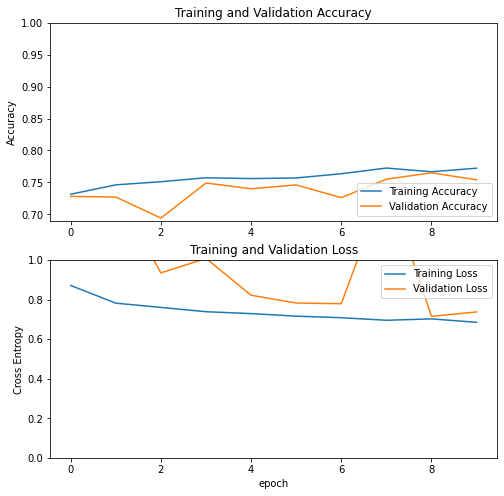

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('/content/drive/My Drive/SavedModels/DiabetesRetinography/')